In [1]:
import matplotlib.pyplot as plt
import include.helpers as h
import numpy as np

In [2]:
scaling_factor = 16

image_file_name = "IMG-0002-00074.dcm"
source_image = h.get_image(image_file_name, scaling_factor=scaling_factor)

gt_file_name = "include/data/liver_GT_074.png"
gt_image = h.get_ground_truth_image(gt_file_name, scaling_factor=scaling_factor)


In [3]:
# Get simi matrices with spatial, the list of graphs are sorted as same order as images below
# [row_image, normalized_image, thresholded_rowImage, amplified_rowImage, threshed_amplified_rowImage]
similarity_matrices = []

no_clusters = [4,8,12]
use_spatial = [True, False]
threshold = [True, False]
edge_amplification = [True, False]

for nc in no_clusters:
    for us in use_spatial:
        for t in threshold:
            for ea in edge_amplification:
                image = h.get_image(image_file_name, scaling_factor=scaling_factor, normalize=True, apply_threshold=t, amplify_edges=ea)
                weight_matrix = h.build_weighMatrix(image, use_spatial=use_spatial)
                similarity_matrices.append({"sim_matrix": weight_matrix, "use_spatial": us, "no_clusters": nc, "threshold": t, "edge": ea})

print("variations: ", len(similarity_matrices))

IndentationError: expected an indented block (<ipython-input-3-9051c3dddb4a>, line 14)

In [4]:
# sparsefy
# build segmentation masks/cluster.labeles and graphs
masks = []
graphs = []
for i in range(len(similarity_matrices)):
  # add weight threshold of 0.7
  similarity_matrices[i]["sim_matrix"] = h.sparsefy_simi_matrix(similarity_matrices[i]["sim_matrix"], sparse_thresh=0.7)
  print(i, similarity_matrices[i])

  # cluster
  labels, _, _ = h.get_spectral_clustering(similarity_matrices[i]["sim_matrix"], n_clusters=similarity_matrices[i]["no_clusters"])
  
  mask = h.get_cluster_image(labels, image.shape)
  masks.append(mask)

  # find best cluster
  best = (0,0,0)
  for l in labels:
    mask_for_label = h.get_mask_with_specLabel(mask=mask, label=l)
    dice_coeff = h.get_dice_coeff(mask_for_label, gt_image)
    hausdorff_dist = h.get_hausdorff_dist(mask_for_label, gt_image)
    if best[0] < dice_coeff:
      best = (dice_coeff, l, hausdorff_dist)
  
  similarity_matrices[i]["dice_coeff"] = best[0]
  similarity_matrices[i]["correct_label"] = best[1]
  similarity_matrices[i]["hausdorff_dist"] = best[2]

  graph = h.build_graph_of_simiMatrix(similarity_matrices[i]["sim_matrix"])
  graphs.append(graph)

  # get avg clustering coeff
  similarity_matrices[i]["avg_clustering_coeff"] = h.get_avg_cluster_coef(graph)

  print(i, similarity_matrices[i])
  # get normalized cut value
  try:
    similarity_matrices[i]["normalized_cut_value"] = h.get_normalizedCut_value(
      graph,
      h.get_subgrapg(graph,
      np.where(mask==similarity_matrices[i]["correct_label"])))
  except ZeroDivisionError:
    print("Failed to specify normalized cut value due to zero division")
    print(mask)
    print(np.where(mask==similarity_matrices[i]["correct_label"]))
    similarity_matrices[i]["normalized_cut_value"] = "ERROR"




0 {'sim_matrix': array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]]), 'no_clusters': 4, 'threshold': True, 'edge': True}
0 {'sim_matrix': array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]]), 'no_clusters': 4, 'threshold': True, 'edge': True, 'dice_coeff': 0.625, 'correct_label': 3, 'hausdorff_dist': 4.47213595499958, 'avg_clustering_coeff': 0.897008811986397}
1 {'sim_matrix': array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]]), '

/Users/albinbaaw/Documents/EIT/kth_year1/p4_data_mining/ID2211-Project/include/helpers.py:294: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


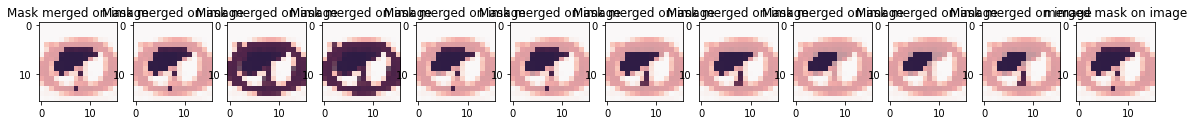

In [5]:
# plot

cluster_labels = []
for i in range(len(similarity_matrices)):
    cluster_labels.append(similarity_matrices[i]["correct_label"])

h.plot_multiple_masks(masks, cluster_labels, source_image)

In [6]:
plt.figure(figsize=(22,5))

plt.subplot(1, 2, 1)
plt.bar(similarity_matrices[0:-1]["avg_clustering_coeff"])
plt.title('Average Clustering coefficients.')

plt.subplot(1, 2, 2)
plt.bar(similarity_matrices[0:-1]["normalized_cut_value"])
plt.title('Normalized cut values')

plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-056573ac0b4a>", line 4, in <module>
    plt.bar(similarity_matrices[:]["avg_clustering_coeff"])
TypeError: list indices must be integers or slices, not str

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core

TypeError: object of type 'NoneType' has no len()